Using device: cpu


/home/kasier/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/kasier/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


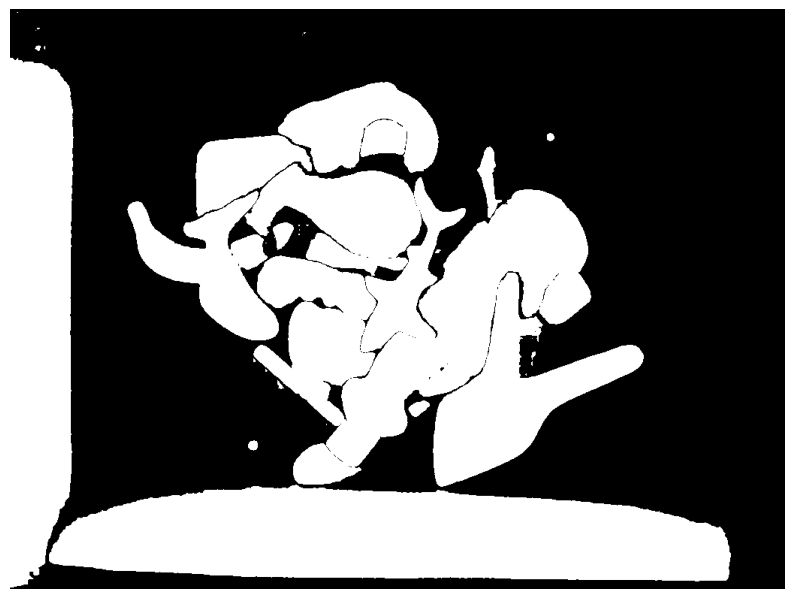

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Cihaz kontrolü: CPU veya CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# SAM2 Modelini Yükleme
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"  # Checkpoint dosya yolu
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"  # Model yapılandırma dosyası yolu

# SAM2 modeli oluştur
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Otomatik maske oluşturucu başlatma (yeni parametrelerle)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,  # Daha fazla örnekleme noktası
    pred_iou_thresh=0.5,  # IoU eşiğini düşür
    stability_score_thresh=0.85,  # Stabilite eşiğini düşür
    min_mask_region_area=100  # Daha küçük alanları maskele
)

# Giriş görüntüsünü yükleme
input_image_path = "images/color_1.jpg"  # Giriş görüntü yolu
image = Image.open(input_image_path)
image = np.array(image.convert("RGB"))

# Maske oluşturma
masks = mask_generator.generate(image)

# Siyah beyaz maske oluşturma fonksiyonu
def create_bw_mask(masks, image_shape):
    """Siyah beyaz maske oluşturur."""
    # Resim boyutlarını belirle
    height, width = image_shape[:2]
    bw_mask = np.zeros((height, width), dtype=np.uint8)  # Tüm pikseller başlangıçta siyah (0)
    for mask in masks:
        segmentation = mask['segmentation']
        bw_mask[segmentation] = 255  # Maske alanlarını beyaz (255) yap
    return bw_mask

# Siyah beyaz maske oluşturma
bw_mask = create_bw_mask(masks, image.shape)

# Maskeyi görselleştirme
plt.figure(figsize=(10, 10))
plt.imshow(bw_mask, cmap="gray")
plt.axis("off")
plt.show()
